# REINFORCE

---

In this notebook, we will train REINFORCE with Farama Foundation's Gymnasium Cartpole environment.

### 1. Import the Necessary Packages

In [1]:
import gymnasium as gym
# gym.logger.set_level(40) # suppress warnings (please remove if gives error)
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

import torch
torch.manual_seed(0) # set random seed
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

### 2. Define the Architecture of the Policy

In [2]:
env = gym.make("CartPole-v1", render_mode="human")
# env.seed(0)
print('observation space:', env.observation_space)
print('action space:', env.action_space)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Policy(nn.Module):
    def __init__(self, s_size=4, h_size=16, a_size=2):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()

        return action.item(), m.log_prob(action)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


### 3. Train the Agent with REINFORCE

In [3]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)

def reinforce(env, n_episodes=2500, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_episodes+1):
        saved_log_probs = []
        rewards = []
        state, info = env.reset(seed=42)

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, terminated, truncated, info = env.step(action)
            rewards.append(reward)

            if terminated or truncated:
                break

        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        discounts = [gamma**i for i in range(len(rewards)+1)]
        R = sum([a*b for a,b in zip(discounts, rewards)])
        
        policy_loss = []

        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

        if np.mean(scores_deque)>=500.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
            break
        
    return scores

env = gym.make("CartPole-v1")
scores = reinforce(env)
env.close()

Episode 100	Average Score: 29.19
Episode 200	Average Score: 52.98
Episode 300	Average Score: 126.09
Episode 400	Average Score: 189.57
Episode 500	Average Score: 119.88
Episode 600	Average Score: 82.65
Episode 700	Average Score: 107.97
Episode 800	Average Score: 70.17
Episode 900	Average Score: 60.67
Episode 1000	Average Score: 82.78
Episode 1100	Average Score: 77.01
Episode 1200	Average Score: 69.83
Episode 1300	Average Score: 166.87
Episode 1400	Average Score: 261.41
Episode 1500	Average Score: 129.58
Episode 1600	Average Score: 119.68
Episode 1700	Average Score: 180.82
Episode 1800	Average Score: 297.94
Episode 1900	Average Score: 237.45
Episode 2000	Average Score: 201.28
Episode 2100	Average Score: 469.16
Episode 2200	Average Score: 116.25
Episode 2300	Average Score: 251.81
Episode 2400	Average Score: 371.83
Environment solved in 2356 episodes!	Average Score: 500.00


### 4. Plot the Scores

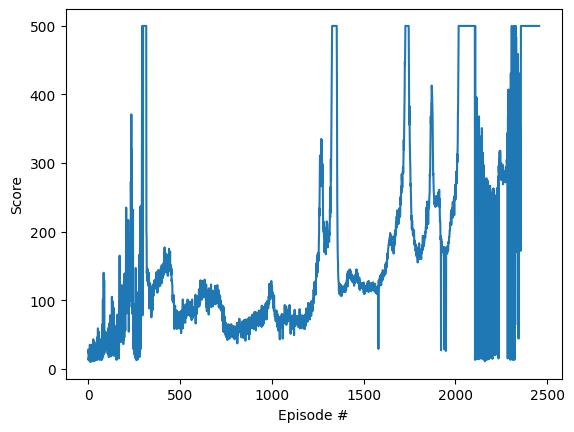

In [4]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [5]:
env = gym.make("CartPole-v1", render_mode="human")

state, info = env.reset(seed=42)

for t in range(1000):
    action, _ = policy.act(state)
    env.render()

    state, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        break 

env.close()